In [1]:
# data manipulation
from difflib import unified_diff
import difflib

# visualize
import matplotlib.pyplot as plt

# pyspark
from pyspark.sql import Row
from pyspark.sql.functions import udf, struct, array, col, lit, regexp_replace, lower
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import types

In [2]:
def get_df(path):
    df = spark.read.json(path)
    return df

In [3]:
def get_count(df):
    # frequency table
    df.groupBy('label').count().orderBy(col('count').desc()).show()
    df.createOrReplaceTempView("wikiedits")
    label_df = spark.sql("SELECT label, count(*) FROM wikiedits GROUP BY label")
    return label_df

In [4]:
def make_diff(old, new):
    return '\n'.join([
        l for l in unified_diff(old.split('\n'), new.split('\n'))
        if l.startswith('+') or l.startswith('-')
    ])

In [5]:
def get_final_df(df):
    # making a diff between text_old and text_new
    diff = make_diff(df.first().text_old, df.first().text_new)
    df = df.withColumn("diff", lit(diff))
    # drop useless features
    drop_list = ['comment', 'name_user', 'title_page', 'url_page',"text_old", "text_new"]
    df = df.select([column for column in df.columns if column not in drop_list])
    #replace empty string  with 'null' 
    from pyspark.sql.functions import col, when
    df = df.withColumn("diff", when(col('diff') != ' ', col('diff')).otherwise(None))
    # remove missing values
    df = df.na.drop(subset = 'diff')
    return df

In [7]:
# Get the data as spark dataframe
df = get_df(path='/Users/zhengxin/Desktop/spark/final/data/*')

+------+-----+
| label|count|
+------+-----+
|  safe| 6708|
|unsafe| 1435|
|vandal|  111|
+------+-----+



<Figure size 576x288 with 0 Axes>

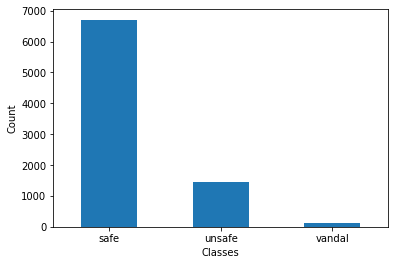

In [8]:
class_dist = get_count(df)

plt.figure(figsize=(8,4))
ax = class_dist.select("*").toPandas().plot.bar(x='label', y='count(1)', rot=0, legend=False)
ax.set_xlabel("Classes")
ax.set_ylabel("Count")

# save figure
plt.savefig('/Users/zhengxin/Desktop/spark/final/fig1.png', dpi=500)

In [9]:
# Get final dataframe
df = get_final_df(df)
# df.show()

In [27]:
# check if input and output is the same before and after saving
# df.count()

901

In [28]:
# save
# df.write.mode("overwrite").save('/Users/zhengxin/Desktop/spark/final/output/data')

In [29]:
# read in data
# read_df = spark.read.parquet('/Users/zhengxin/Desktop/spark/final/output/data')

In [30]:
# check if input and output is the same before and after saving
# read_df.count()

901